# **Lesson 03**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
import scipy
from scipy.special import erf
from numpy import exp
from numpy.lib.scimath import log, sqrt


In [2]:
# plot parameters
import sys
sys.path.append('./../Libraries/')
import plt_params

# Plain vanilla option pricing

Black-Scholes theory assumes that the time evolution of the asset price is stochastic and exhibits geometric Brownian motion (GBM) with constant risk-free interest rate $r$ and volatility $\sigma$.

Black-Scholes analytic solution for the price at time t<T:
- European Call-option price:
$$ C\left[ S(t),t \right] = S(t) N(d_1) -K e^{-r(T-t)} N(d_2) $$
- European Put-option price:
$$ P\left[ S(t),t \right] = S(t) \left[ N(d_1)-1\right] -K e^{-r(T-t)} \left[ N(d_2)-1\right]$$

where 
$$d_1 = \frac{1}{\sigma\sqrt{T-t}}\left[ \ln \left( \frac{S(t)}{K} \right) + \left( r+\frac{\sigma^2}{2} (T-t) \right)\right]$$

where $d_2 = d_1 - \sigma\sqrt{T-t}$, and where
$$ N(x) = \int_{-\infty}^{x} dz \, e^{-\frac{z^2}{2}} = \frac{1}{2} \left[ 1+ {\rm erf} \left( \frac{x}{\sqrt{2}}\right) \right]$$
is the cumulative of Gaussian $\sim \mathcal{N}(\mu=0,\sigma^2=1)$,
and where
$${\rm erf}(x) = \frac{2}{\sqrt{\pi}}\int_{0}^{x} dz \, e^{-z^2}$$

In [3]:
# analytic solution for comparison
# data
S0 = 100.
K = 100.
T = 1.
r = 0.1
sigma = 0.25
t=0

def N(x):
    return 0.5 * (1. + erf(x / sqrt(2.)))

def black_scholes(S0, K, T, r, sigma):
    d1 = 1./(sigma * sqrt(T)) * (log(S0 / K) + (r + (sigma**2) / 2.) * T)
    d2 = d1 - sigma * sqrt(T)
    C = S0 * N(d1) - K * exp(-r * T) * N(d2)
    P = S0 *(N(d1) - 1.) - K * exp(-r * T) * (N(d2)-1.)
    return C, P

if __name__ == "__main__":
    call, put = black_scholes(S0, K, T, r, sigma)
    print(" == BLACK-SCHOLES ==")
    print("call: ", call)
    print("put: ", put)

 == BLACK-SCHOLES ==
call:  14.975790778311286
put:  5.4595325819072364


# Exercise 03.1

By using the following parameters: 
- asset price at $t=0$: $S(0)=100$
- delivery time: $T=1$
- strike price: $K=100$
- risk-free interest rate: $r=0.1$
- volatility: $\sigma=0.25$

compute at time $t=0$ **via Monte Carlo** the European call-option price, $C[S(0),0]$, and put-option price, $P[S(0),0]$:

1. By sampling **directly** the final asset price $S(T)$ for a $GBM(r,\sigma^2)$
2. By sampling the discretized $GBM(r,\sigma^2)$ path of the asset price
dividing $[0,T]$ in $10^2$ time intervals: $S(0)$, $S(t_1)$, $S(t_2)$, ... up to $S(t_{100}=T=1)$

Make four pictures for the estimation of the European call-option prices, $C[S(0),0]$ (direct and discretized), and put-option prices, $P[S(0),0]$ (direct and discretized), with their uncertainties with a large number of asset prices at time $t=T$, say $M\ge 10^4$, as a function of the number of blocks, $N$. As usual, in computing statistical uncertainties, use data blocking.

## Solution


### Financial market

The financial market is a place were buyers and sellers can exchange money, invest it in commodities and securities. All the products in a market have a **spot price** $S(t)$, that is a complicated function of time ad it's determined by the demand and the supply. People can make deals and contracts with each other, always assuming a risk and hoping in a profit. Thus it would be very useful to predict how $S(t)$ will evolve during time. In financial market it is stored a lot of information, making financial quantities time series practically impossible to predict exactly.

A market is **efficient** if all the participants can quickly gain all the information they need about trading, if it is simple to buy and sell products at any time and if there is low financial friction, that is if the trading costs are low if compared to the transaction volumes. In other words an efficient market contains at the present time all information about its development, and this fact leads physicists to model it with a Markov process.

### Options

Options are a financial product where the **holder** obtains from the **writer** the right to buy (**call option**) or to sell (**put option**) an asset at a prescribed price, called **strike price** $K$. In this type of contracts only the writer has an obligation, and in the case of the European options, the contract can be exercised only at its expiry date $T$.

Obviously, the holder will exercise the option only if it gives him a profit, that is, depending on the option type:
- Call option: $\max[0, S(T)-K]$
- Put option: $\max[0, K-S(T)]$

where $S(t)$ is the spot price of the asset that is object of the option at the moment in which the option can be used ($T$). Note that to obtain the profit at the moment of the contract stipulation, one has to discount the previous expression multiplying them by a factor $e^{\mu T}$, corresponding to the growth that the asset price would have undergone by the time T due to the drift.

### Geometric Brownian Motion
The **Brownian motion** is the stochastic process that a microscopic particle undergoes when it is plunged in a fluid with the same density as the particle. It is also called **Wiener process** (WP) and it is defined as the stochastic process satisfying:
- $W(0) = 0$
- $W(t) - W(s)$ (increments) are stationary and independent
- For $t>s$, $W(t) - W(s)$ is normally distributed $\mathcal{N}(0,t-s)$

The WP is a diffusion process and, given increments $Z_i \sim \mathcal{N}(0,1)$, can be sampled with:

$$ W(t_{i+1}) = W(t_i) + Z_{i+1}\sqrt{t_{i+1} - t_i} \ . $$

A first attempt to model the financial market is to assume two principal contributions to the asset price: a deterministic one and a stochastic one.
The first is parametrized by the drift $\mu$ and gives information about the growing rate of an asset price, while the second contains the volatility $\sigma$ of $S(t)$. Combining these two contribution we obtain an equation for $S(t)$:

$$ dS(t) = \mu S(t) dt + \sigma S(t) dW(t) \ , $$

which defines a variant of the WP: the **Geometric Brownian Motion** (GBM).

Given an asset price $S\sim GBM(\mu,\sigma^2)$, with initial value $S(0)$, then $S(t)$ can be sampled **directly** as:

$$S(t) = S(0) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)t+\sigma W(t)\right]$$

where $W(t)\sim\mathcal{N}(0,t)$.
Moreover, since the increments of $W$ are independent and normally distributed, the simple recursive procedure for sampling discretized values of $S\sim GBM(\mu,\sigma^2)$ at $t_1 < t_2 < … < t_n$ is:

$$S(t_{i+1}) = S(t_i) \exp\left[ \left(\mu-\frac{1}{2}\sigma^2\right)(t_{i+1}-t_i)
+\sigma Z_{i+1}\sqrt{t_{i+1}-t_i}\right]$$

with $Z_i \sim \mathcal{N}(0,1)$, and this is **indirect sampling**.

### Code

To compute the value of $S(t)$ I used data blocking, implementing a new derived class of `BlockingAverage`, called `BA_Option`. It gives the possibility to set the number of steps done for the sampling, and has as a data member also a pointer to a function defining the profit (and so the type of option), so it can be used for both the call and the put options, in direct and indirect sampling.

Here I show the `Increase()` method of the class `BA_Option`:
```c++
double BA_Option :: Increase() {
    
    double val = 0., price = initial_;
    double dt = static_cast<double>(stop_ - start_)/nstep_;

    for(int i=0 ; i<dim_ ; i++) {
        for(int j=0 ; j<nstep_ ; j++) {
            price *= std::exp( (drift_ - 0.5*std::pow(volatility_,2))*dt + volatility_*rnd_.Gauss(0.,1.)*std::sqrt(dt));
        }
        val += std::exp(-drift_*stop_) * Profit_(price, strike_);
        price = initial_;
    }

    return val/dim_;

}
```

### Direct sampling

In [4]:
# import the files
dir_call = np.loadtxt('03.1/direct_call.csv', delimiter=',', skiprows=1)
dir_put = np.loadtxt('03.1/direct_put.csv', delimiter=',', skiprows=1)

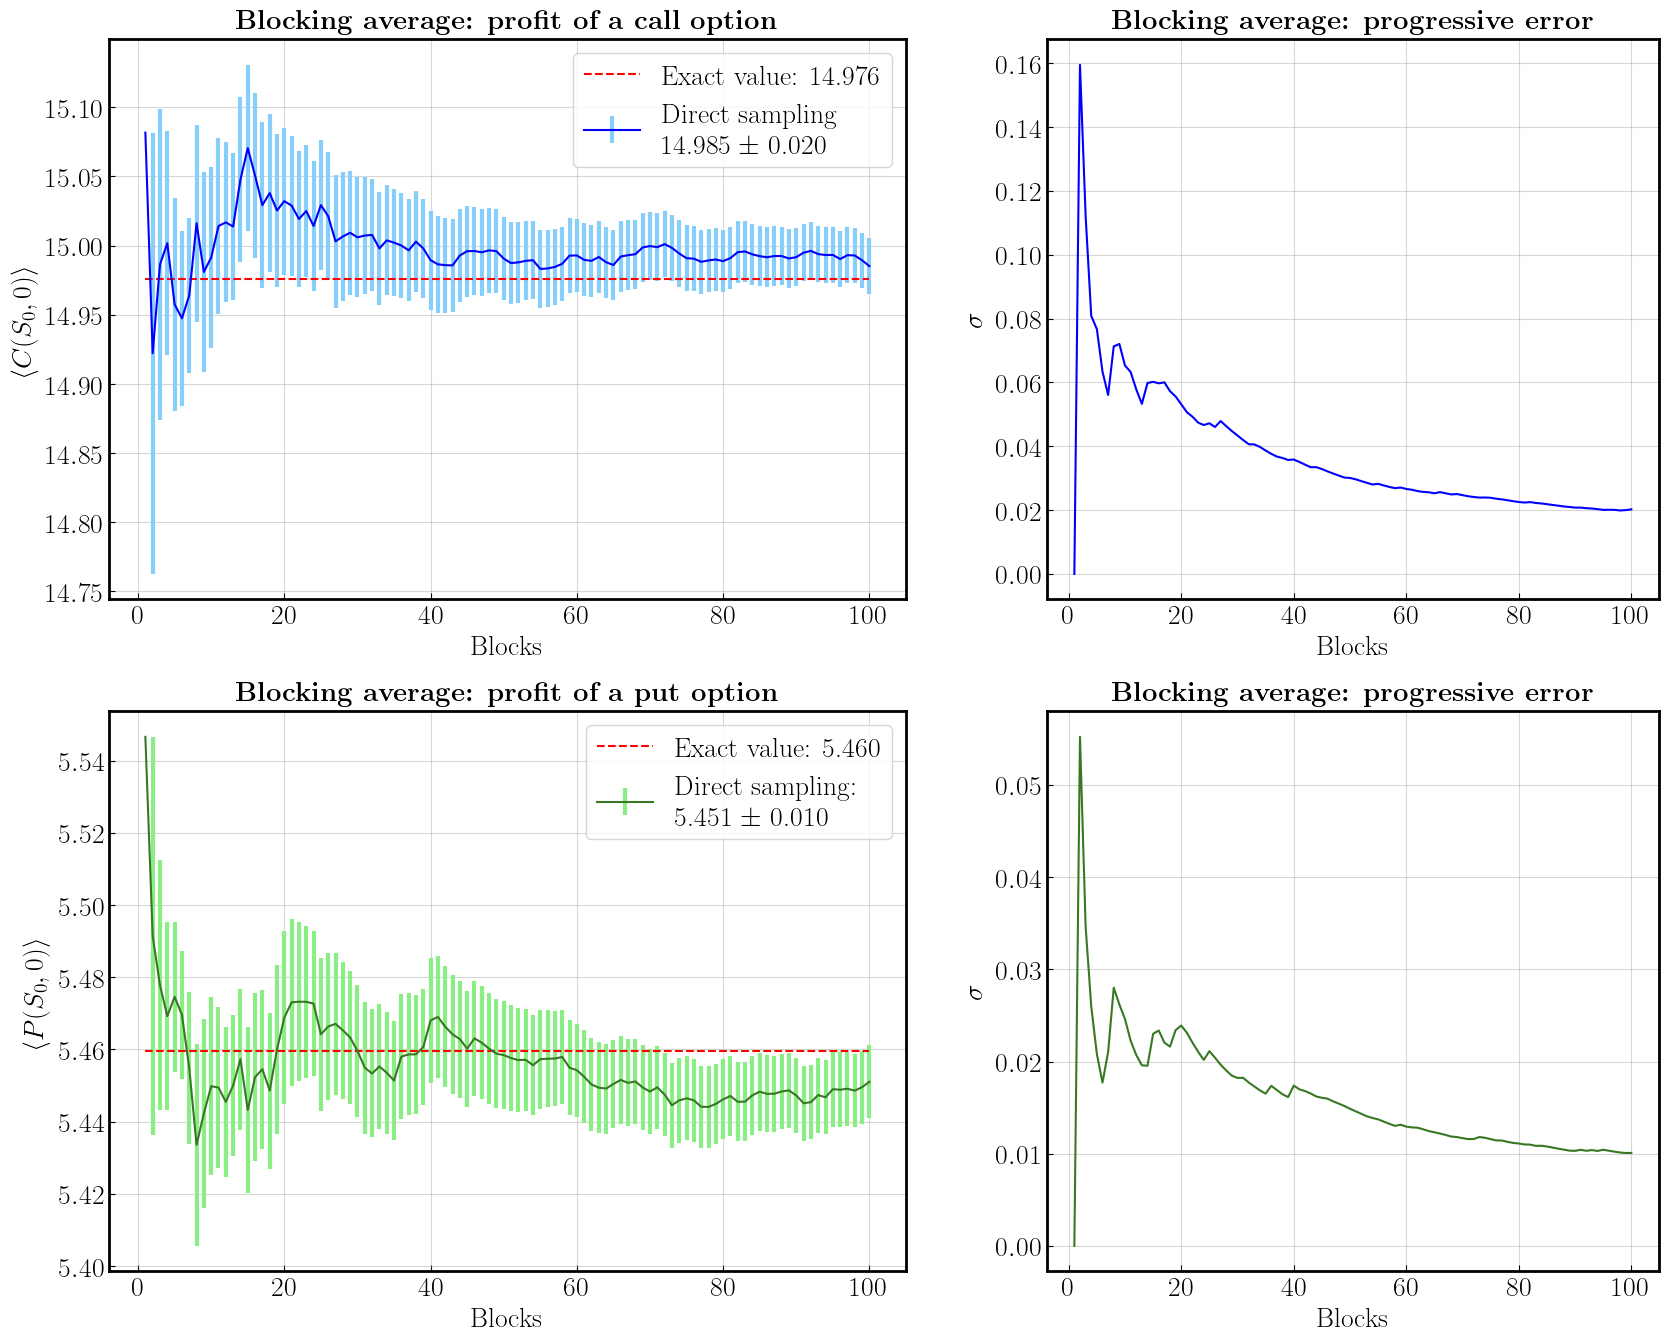

In [5]:
# plots
fig, axs = plt.subplots(2, 2, figsize=(20,16), gridspec_kw={'width_ratios': [1.3, 1]})

axs[0,0].errorbar(dir_call[:,0], dir_call[:,2], yerr=dir_call[:,3], fmt='-', color='blue', ecolor='lightskyblue', elinewidth=3, label='Direct sampling\n' + format(dir_call[-1,2], '.3f') + r' $\pm$ ' + format(dir_call[-1,3], '.3f'))
exact_call = call*np.ones(dir_call.shape[0])
axs[0,0].plot(dir_call[:,0], exact_call, linestyle='--', color='red', label='Exact value: ' + format(call, '.3f'))

axs[0,0].set_title(r'\textbf{Blocking average: profit of a call option}', pad=8)
axs[0,0].set_xlabel('Blocks')
axs[0,0].set_ylabel(r'$\langle C(S_0,0) \rangle$', labelpad=6)
axs[0,0].legend(loc='upper right')


axs[0,1].plot(dir_call[:,0], dir_call[:,3], color='blue')

axs[0,1].set_title(r'\textbf{Blocking average: progressive error}', pad=8)
axs[0,1].set_xlabel('Blocks')
axs[0,1].set_ylabel(r'$\sigma$', labelpad=6)


axs[1,0].errorbar(dir_put[:,0], dir_put[:,2], yerr=dir_put[:,3], fmt='-', color='#387723', ecolor='#8BEE84', elinewidth=3, label='Direct sampling:\n' + format(dir_put[-1,2], '.3f') + r' $\pm$ ' + format(dir_put[-1,3], '.3f'))
exact_put = put*np.ones(dir_put.shape[0])
axs[1,0].plot(dir_put[:,0], exact_put, linestyle='--', color='red', label='Exact value: ' + format(put, '.3f'))

axs[1,0].set_title(r'\textbf{Blocking average: profit of a put option}', pad=8)
axs[1,0].set_xlabel('Blocks')
axs[1,0].set_ylabel(r'$\langle P(S_0,0) \rangle$', labelpad=6)
axs[1,0].legend()


axs[1,1].plot(dir_put[:,0], dir_put[:,3], color='#387723')

axs[1,1].set_title(r'\textbf{Blocking average: progressive error}', pad=8)
axs[1,1].set_xlabel('Blocks')
axs[1,1].set_ylabel(r'$\sigma$', labelpad=6)
              
plt.show()

This plots show the progressive value of the profit for a call (upper plots) and a put (lower plots) options with their error having done direct sampling and also the progressive value of the errors themselves. The obtained result is compatible in both cases within one $\sigma$ with the expected values, computed using the Black-Scholes theory.

**Plot parameters**:
- Extractions: $10^6$
- Blocks: $10^2$
- Extractions in each block: $10^4$

### Indirect sampling

In [6]:
# import the files
indir_call = np.loadtxt('03.1/indirect_call.csv', delimiter=',', skiprows=1)
indir_put = np.loadtxt('03.1/indirect_put.csv', delimiter=',', skiprows=1)

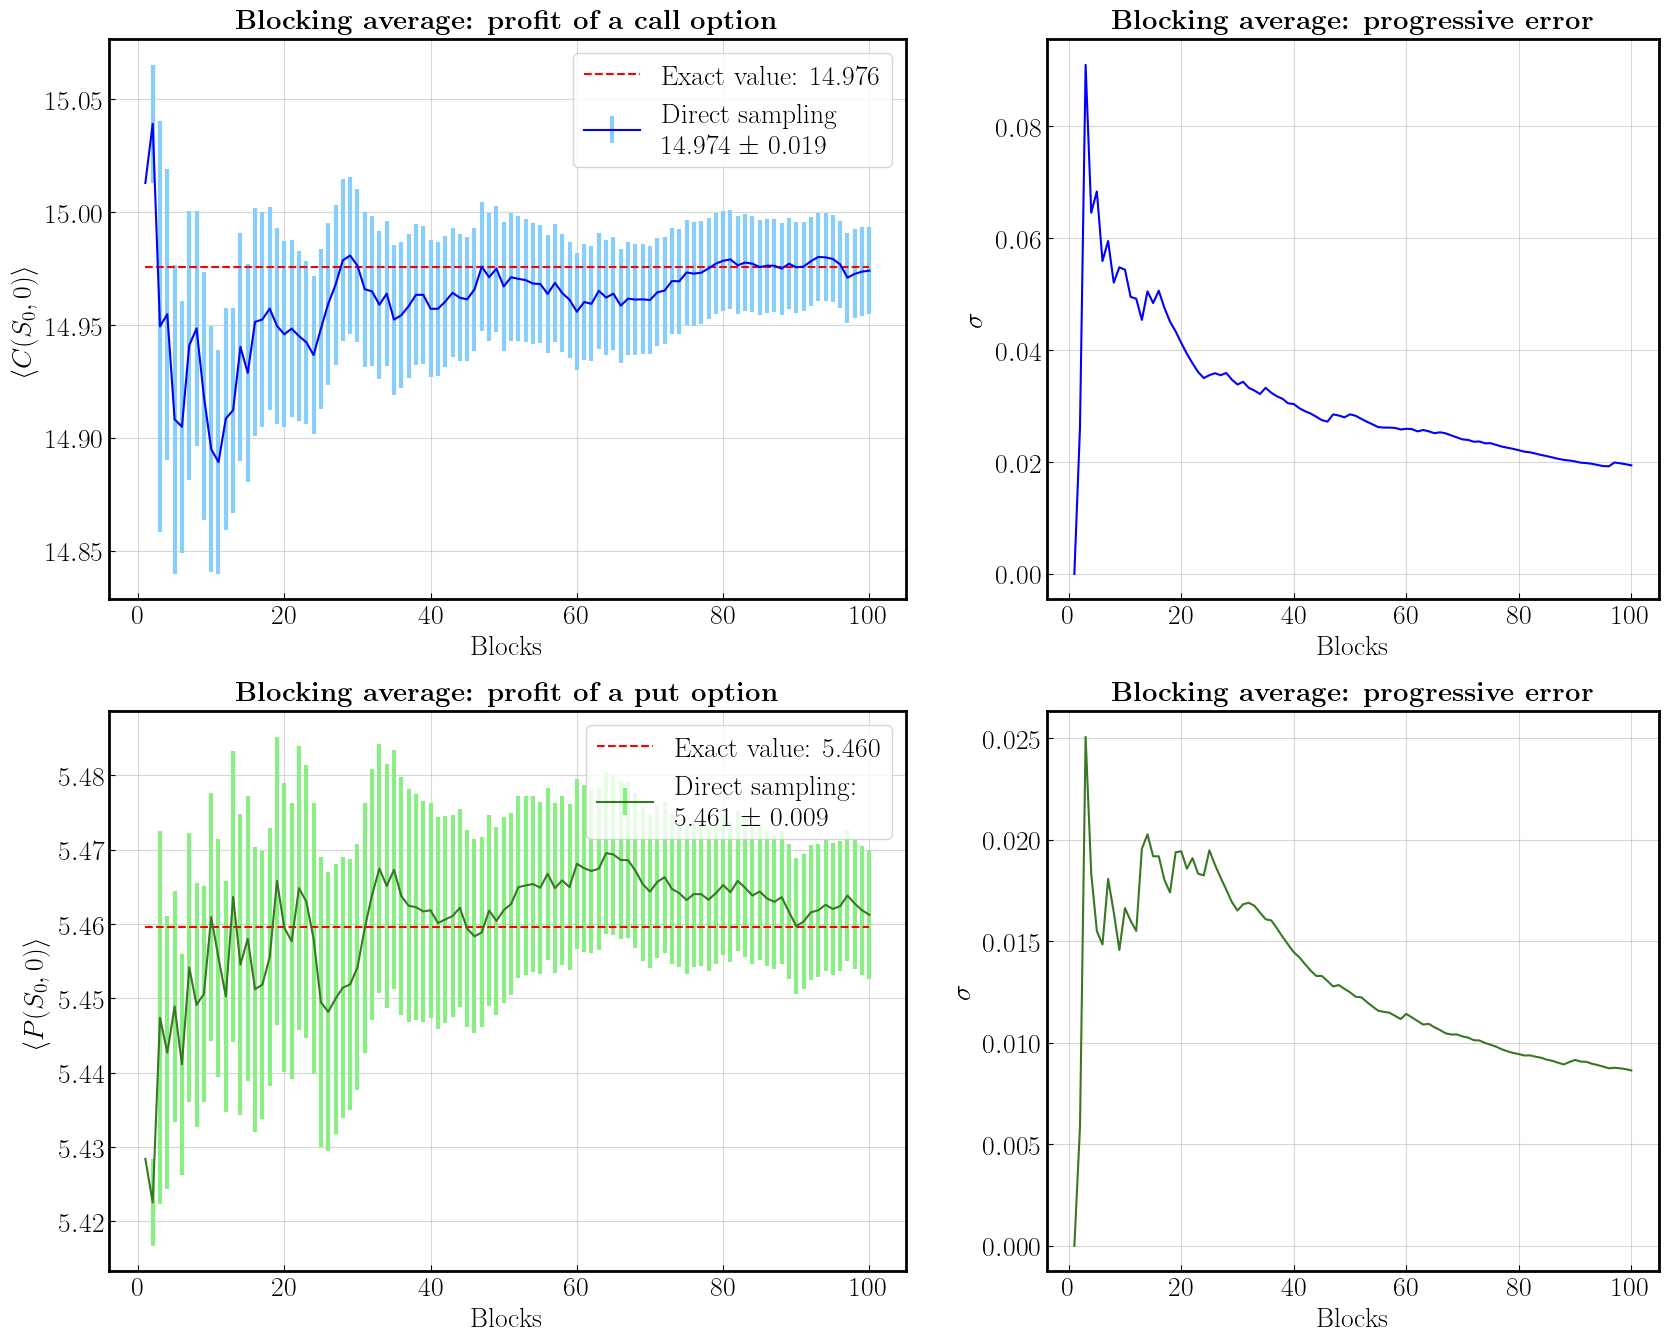

In [7]:
# plots
fig, axs = plt.subplots(2, 2, figsize=(20,16), gridspec_kw={'width_ratios': [1.3, 1]})

axs[0,0].errorbar(indir_call[:,0], indir_call[:,2], yerr=indir_call[:,3], fmt='-', color='blue', ecolor='lightskyblue', elinewidth=3, label='Direct sampling\n' + format(indir_call[-1,2], '.3f') + r' $\pm$ ' + format(indir_call[-1,3], '.3f'))
exact_call = call*np.ones(indir_call.shape[0])
axs[0,0].plot(indir_call[:,0], exact_call, linestyle='--', color='red', label='Exact value: ' + format(call, '.3f'))

axs[0,0].set_title(r'\textbf{Blocking average: profit of a call option}', pad=8)
axs[0,0].set_xlabel('Blocks')
axs[0,0].set_ylabel(r'$\langle C(S_0,0) \rangle$', labelpad=6)
axs[0,0].legend(loc='upper right')


axs[0,1].plot(indir_call[:,0], indir_call[:,3], color='blue')

axs[0,1].set_title(r'\textbf{Blocking average: progressive error}', pad=8)
axs[0,1].set_xlabel('Blocks')
axs[0,1].set_ylabel(r'$\sigma$', labelpad=6)


axs[1,0].errorbar(indir_put[:,0], indir_put[:,2], yerr=indir_put[:,3], fmt='-', color='#387723', ecolor='#8BEE84', elinewidth=3, label='Direct sampling:\n' + format(indir_put[-1,2], '.3f') + r' $\pm$ ' + format(indir_put[-1,3], '.3f'))
exact_put = put*np.ones(indir_put.shape[0])
axs[1,0].plot(indir_put[:,0], exact_put, linestyle='--', color='red', label='Exact value: ' + format(put, '.3f'))

axs[1,0].set_title(r'\textbf{Blocking average: profit of a put option}', pad=8)
axs[1,0].set_xlabel('Blocks')
axs[1,0].set_ylabel(r'$\langle P(S_0,0) \rangle$', labelpad=6)
axs[1,0].legend(loc='upper right')


axs[1,1].plot(indir_put[:,0], indir_put[:,3], color='#387723')

axs[1,1].set_title(r'\textbf{Blocking average: progressive error}', pad=8)
axs[1,1].set_xlabel('Blocks')
axs[1,1].set_ylabel(r'$\sigma$', labelpad=6)
              
plt.show()

This plots show the progressive value of the profit for a call (upper plots) and a put (lower plots) options with their error having done indirect sampling and also the progressive value of the errors themselves. The obtained result is compatible in both cases within one $\sigma$ with the expected values, computed using the Black-Scholes theory. It can be noted that with indirect sampling the algorithm converges faster, and in the case of the put option the obtained value is also closer to the theory.

**Plot parameters**:
- Extractions: $10^6$
- Blocks: $10^2$
- Extractions in each block: $10^4$